# Ejercicio

Generar un dataset (dos conjuntos Gaussianos con diferente media y DS, N=50 c/u, uno con etiqueta A y otro con etiqueta B).

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report

In [2]:
def dataset(mu1:float, sigma1:float, mu2:float, sigma2:float, n_samples:int):
    
    
    # Creates a seed for random creation
    np.random.seed(21)

    # Values for target 'A'
    target_A = pd.DataFrame(np.random.normal(loc = mu1, scale = sigma1, size = (n_samples,1)),
                              columns=['Val'])
    target_A['Etiq'] = 'A'

    # Values for target 'B'
    target_B = pd.DataFrame(np.random.normal(loc = mu2, scale = sigma2, size = (n_samples,1)),
                              columns=['Val'])
    target_B['Etiq'] = 'B'

    # Join both target values in one dataframe
    dataset = pd.concat([target_A, target_B])
    dataset = dataset.reset_index(drop=True)

    return dataset

def predict(X, threshold):
    
    y_pred = []
    
    for value in X:
        
        if value > threshold:
            y_pred.append('B')
        else:
            y_pred.append('A')

    return np.array(y_pred)

def evaluate(y_actual, y_pred, show=True):
    
  # Gets and displays the report
    report = classification_report(y_actual, y_pred, output_dict=True)
    print(classification_report(y_actual, y_pred))
    accuracy = report['accuracy']
  
  # Calculates the confusion matrix and shows it
    confusion_matrix = pd.crosstab(y_actual, y_pred, rownames=['True labels'], colnames=['Predicted labels'])
    if show:
        sns.heatmap(confusion_matrix, annot=True, cbar=False)
        plt.title(f'Matriz de confusión - Accuracy: {accuracy}')
        plt.show()
  
    return report, confusion_matrix


# Prueba 1.

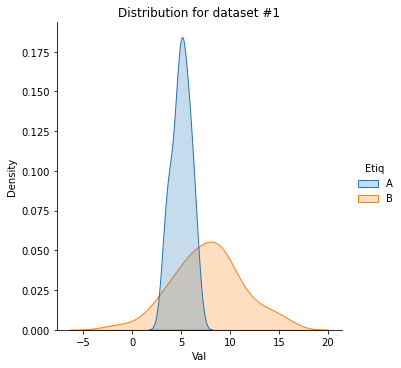

In [21]:
df1 = dataset(mu1=5.0, sigma1=1.0, 
                          mu2=7.0, sigma2=3.0, 
                          n_samples=50)

sns.displot(data=df1, x='Val', hue='Etiq', kind='kde', fill=True)
plt.title('Distribution for dataset #1')
plt.show()

# Curva ROC 1.

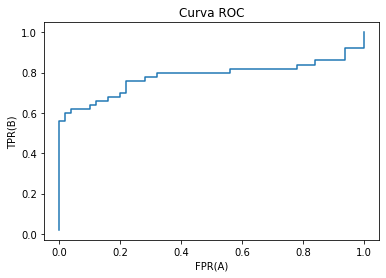

In [22]:
# Variables to execute for counting
tpr, fpr = [], []
TP, FP = 0, 0

# Gets number os samples for each target value
samples_A = df1[df1['Etiq'] == 'A'].shape[0]
samples_B = df1[df1['Etiq'] == 'B'].shape[0]

# Sort values by feature values
dataset_ = df1.copy()
dataset_ = dataset_.sort_values(by = 'Val', ascending=False).reset_index(drop=True)

# Iterates over each row in `dataset`
# `row` is a tuple that has the following values (index, column1, column2)
for row in dataset_.itertuples():
    
# `row[2]` takes the target value
    if row[2] == 'A':
      FP = FP + 1
    else:
      TP = TP + 1

    tpr.append(TP/samples_B)
    fpr.append(FP/samples_A)

  # Displays ROC curve 
plt.plot(fpr, tpr)
plt.title('Curva ROC')
plt.xlabel("FPR(A)")
plt.ylabel("TPR(B)")
plt.show()

# Calculamos el punto mas lejano

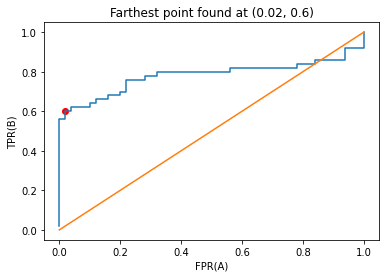

In [23]:
roc_curve_points = list(zip(fpr, tpr))
total_points = len(roc_curve_points)

# Gets the pairs of points of the line
points = list(np.linspace(start=0.0, stop=1.0, num=total_points))
line_points = list(zip(points, points))

# Calculates Euclidean distance for each pair points
distances = []
for index in range(total_points):
    roc_point = np.array(roc_curve_points[index])
    line_point = np.array(line_points[index])
    distance =  np.sqrt(np.sum(np.square(line_point - roc_point)))
    distances.append(distance)

  # Gets the farthest ROC curve point from line
distances = np.array(distances)
farthest_point = roc_curve_points[np.argmax(distances)]

plt.plot(fpr, tpr)
plt.plot(points, points)
plt.scatter(farthest_point[0], farthest_point[1], c='red')
plt.title(f'Farthest point found at {farthest_point}')
plt.xlabel("FPR(A)")
plt.ylabel("TPR(B)")
plt.show()

# Obtenemos el umbral de decisión.

In [25]:
x_point, y_point = farthest_point
min1, min2 = 1, 1
umbral_tp, umbral_fp = 0, 0

  # Iterates in range `n_samples*2` because we expect each target value has 
  # same number of samples and there's only two targets: 'A' and 'B'
for i in range(50*2):
    
    div = i/50
    diff_x = np.abs(div - x_point)
    diff_y = np.abs(div - y_point)

    if diff_x < min1:
        
        min1 = diff_x
        umbral_fp = i
    
    if diff_y < min2:
        min2 = diff_y
        umbral_tp = i

print("FPR = {}, es equivalente a: {}/{}".format(x_point, umbral_fp, 50))
print("TPR = {}, es equivalente a: {}/{}".format(y_point, umbral_tp, 50))


  # Gets the value in 'Val' column that satisfies 
  # the count of `umbral_fp` and `umbral_tp`
  # ---------------------------------------------
A_count, B_count = 0, 0
umbral_value = 0

# Sort values by feature values
dataset_ = df1.copy()
dataset_ = dataset_.sort_values(by = 'Val', ascending=False).reset_index(drop=True)

for row in dataset_.itertuples():
    
    if row[2] == 'A':
        A_count = A_count + 1
    else:
        B_count = B_count + 1

    # Checks if the count of targets 'A' and 'B' matches the 
    # thresholds for fp and tp
    if A_count == umbral_fp and B_count == umbral_tp:
        

      # If so, gets the value in firts column ('Val') from `dataset` 
      # and stops the for loop
        umbral_value = row[1]
        break

print("\nPara A = {} y B = {}, el valor es {}".format(A_count, B_count, umbral_value))


FPR = 0.02, es equivalente a: 1/50
TPR = 0.6, es equivalente a: 30/50

Para A = 1 y B = 30, el valor es 6.611533700928603


# Se clasifica respecto al valor de umbral encontrado

In [28]:
X = df1['Val'].to_numpy()
y_pred = predict(X, umbral_value)

# Se obtiene el reporte de clasificación del modelo

              precision    recall  f1-score   support

           A       0.70      0.98      0.82        50
           B       0.97      0.58      0.72        50

    accuracy                           0.78       100
   macro avg       0.83      0.78      0.77       100
weighted avg       0.83      0.78      0.77       100



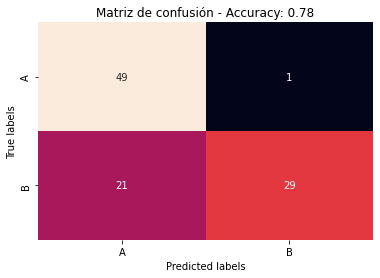

In [30]:
y_actual = df1['Etiq'].to_numpy()
summary1, cm1 = evaluate(y_actual, y_pred)

Dado la forma en la que estan distribuidos los datos, el clasificador obtiene un **f1 score del 78%**

# Prueba 2.

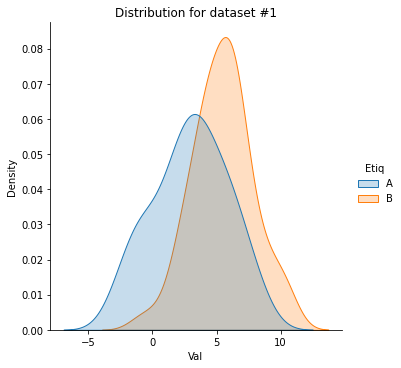

In [4]:
df1 = dataset(mu1=3.0, sigma1=3.0, 
                          mu2=5.0, sigma2=2.0, 
                          n_samples=50)

sns.displot(data=df1, x='Val', hue='Etiq', kind='kde', fill=True)
plt.title('Distribution for dataset #1')
plt.show()

# Curva ROC 2

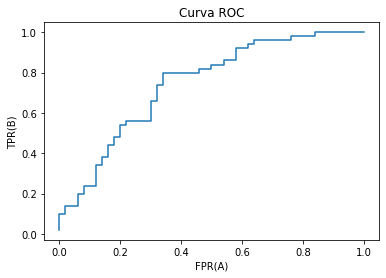

In [6]:
# Variables to execute for counting
tpr, fpr = [], []
TP, FP = 0, 0

# Gets number os samples for each target value
samples_A = df1[df1['Etiq'] == 'A'].shape[0]
samples_B = df1[df1['Etiq'] == 'B'].shape[0]

# Sort values by feature values
dataset_ = df1.copy()
dataset_ = dataset_.sort_values(by = 'Val', ascending=False).reset_index(drop=True)

# Iterates over each row in `dataset`
# `row` is a tuple that has the following values (index, column1, column2)
for row in dataset_.itertuples():
    
# `row[2]` takes the target value
    if row[2] == 'A':
      FP = FP + 1
    else:
      TP = TP + 1

    tpr.append(TP/samples_B)
    fpr.append(FP/samples_A)

  # Displays ROC curve 
plt.plot(fpr, tpr)
plt.title('Curva ROC')
plt.xlabel("FPR(A)")
plt.ylabel("TPR(B)")
plt.show()

# Calculamos el punto mas lejano

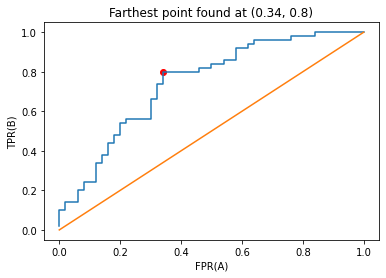

In [7]:
roc_curve_points = list(zip(fpr, tpr))
total_points = len(roc_curve_points)

# Gets the pairs of points of the line
points = list(np.linspace(start=0.0, stop=1.0, num=total_points))
line_points = list(zip(points, points))

# Calculates Euclidean distance for each pair points
distances = []
for index in range(total_points):
    roc_point = np.array(roc_curve_points[index])
    line_point = np.array(line_points[index])
    distance =  np.sqrt(np.sum(np.square(line_point - roc_point)))
    distances.append(distance)

  # Gets the farthest ROC curve point from line
distances = np.array(distances)
farthest_point = roc_curve_points[np.argmax(distances)]

plt.plot(fpr, tpr)
plt.plot(points, points)
plt.scatter(farthest_point[0], farthest_point[1], c='red')
plt.title(f'Farthest point found at {farthest_point}')
plt.xlabel("FPR(A)")
plt.ylabel("TPR(B)")
plt.show()

# Obtenemos el umbral de decisión

In [8]:
x_point, y_point = farthest_point
min1, min2 = 1, 1
umbral_tp, umbral_fp = 0, 0

  # Iterates in range `n_samples*2` because we expect each target value has 
  # same number of samples and there's only two targets: 'A' and 'B'
for i in range(50*2):
    
    div = i/50
    diff_x = np.abs(div - x_point)
    diff_y = np.abs(div - y_point)

    if diff_x < min1:
        
        min1 = diff_x
        umbral_fp = i
    
    if diff_y < min2:
        min2 = diff_y
        umbral_tp = i

print("FPR = {}, es equivalente a: {}/{}".format(x_point, umbral_fp, 50))
print("TPR = {}, es equivalente a: {}/{}".format(y_point, umbral_tp, 50))


  # Gets the value in 'Val' column that satisfies 
  # the count of `umbral_fp` and `umbral_tp`
  # ---------------------------------------------
A_count, B_count = 0, 0
umbral_value = 0

# Sort values by feature values
dataset_ = df1.copy()
dataset_ = dataset_.sort_values(by = 'Val', ascending=False).reset_index(drop=True)

for row in dataset_.itertuples():
    
    if row[2] == 'A':
        A_count = A_count + 1
    else:
        B_count = B_count + 1

    # Checks if the count of targets 'A' and 'B' matches the 
    # thresholds for fp and tp
    if A_count == umbral_fp and B_count == umbral_tp:
        

      # If so, gets the value in firts column ('Val') from `dataset` 
      # and stops the for loop
        umbral_value = row[1]
        break

print("\nPara A = {} y B = {}, el valor es {}".format(A_count, B_count, umbral_value))


FPR = 0.34, es equivalente a: 17/50
TPR = 0.8, es equivalente a: 40/50

Para A = 17 y B = 40, el valor es 3.9469689895896587


# Se clasifica respecto al valor de umbral encontrado

In [9]:
X = df1['Val'].to_numpy()
y_pred = predict(X, umbral_value)

# Se obtiene el reporte de clasificación del modelo

              precision    recall  f1-score   support

           A       0.75      0.66      0.70        50
           B       0.70      0.78      0.74        50

    accuracy                           0.72       100
   macro avg       0.72      0.72      0.72       100
weighted avg       0.72      0.72      0.72       100



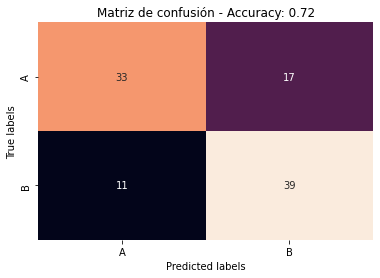

In [10]:
y_actual = df1['Etiq'].to_numpy()
summary1, cm1 = evaluate(y_actual, y_pred)

Se puede observar en estas dos pruebas de que mientras las distribuciones se encuentren cercanas o cruzadas, la precisión tiende a decaer, se podria hacer otra prueba para asi verificar de que con distribuciones separadas se obtendria un mejor resultado. 